# WTI Cushing Crude Oil Time Series Forecast: Anomaly Detection

In North America this generally refers to the WTI Cushing Crude Oil Spot Price West Texas Intermediate (WTI), also known as Texas Light Sweet, a type of crude oil used as a benchmark in oil pricing and the underlying commodity of New York Mercantile Exchange's oil futures contracts. We will use the price evolution [data source](https://fred.stlouisfed.org/series/DCOILWTICO) over the last 40 years as our time series forecast toy case.

In the current notebook we will learn 
* How to decompose a time series into trend, seasonality and residuals
* Most common methods for time series forecasting
* How to establish a threshold to determine what is an anomaly

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error
import scipy.stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

/Users/celsadiaz/.pyenv/versions/3.6.2/envs/redi/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Load and visualize data

In [2]:
# Load historical West Texas Intermediate (NYMEX) Crude Oil price (dollars per barrel) time series
crude_price = pd.read_csv('DCOILWTICO.csv').rename(columns={'DCOILWTICO':'Dollars_per_barrel',
                                                            'DATE':'date (day)'})

In [3]:
crude_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8418 entries, 0 to 8417
Data columns (total 2 columns):
date (day)            8418 non-null object
Dollars_per_barrel    8418 non-null object
dtypes: object(2)
memory usage: 131.6+ KB


In [4]:
# See that the prices are in the csv as strings, we need to convert the series into floats
crude_price['Dollars_per_barrel'] = crude_price['Dollars_per_barrel'].convert_objects(convert_numeric=True)

In [5]:
# See that there are some missing values, we will drop this records
print(crude_price.isnull().sum())

crude_price = crude_price.dropna()

print(crude_price.isnull().sum())

date (day)              0
Dollars_per_barrel    281
dtype: int64
date (day)            0
Dollars_per_barrel    0
dtype: int64


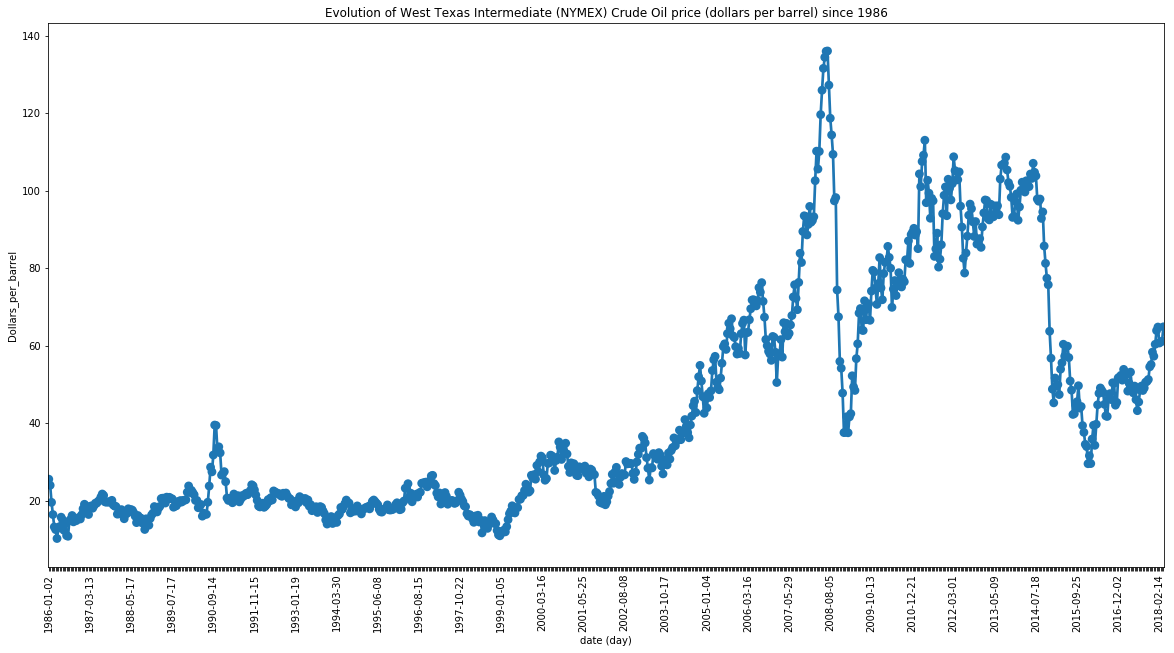

In [91]:
# Original data
plt.figure(figsize=(20,10))

# There are too many points and therefore we will plot only value per each 10
ax = sns.pointplot(x='date (day)',y='Dollars_per_barrel', data=crude_price.iloc[::10])
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 30 == 0:  # every 30th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_ = plt.xticks(rotation=90)
_ = plt.title("Evolution of West Texas Intermediate (NYMEX) Crude Oil price (dollars per barrel) since 1986")

## Decompose the time series

In [6]:
def log_scale_and_decompose_time_series(data, column_to_decompose, frequency, model='multiplicative', two_sided=False):
    data_ = data.copy()
    
    # Manual extraction of the exponential trend applying the logarithm of the values
    log_column_name = 'log_' + column_to_decompose
    data_[log_column_name] = data_[column_to_decompose].apply(lambda x: np.log(x))
    
    # Decompose log_trend_open in log_trend_open_trend, log_trend_open_season, log_trend_open_resid
    result_open = seasonal_decompose(data_[log_column_name].tolist(), model=model, freq=frequency, 
                                 two_sided=two_sided)
    result_open.plot()
    plt.show()
    
    trend_column_name = 'log_' + column_to_decompose + '_trend' 
    seasonal_column_name = 'log_' + column_to_decompose + '_seasonal' 
    residual_column_name = 'log_' + column_to_decompose + '_residual' 
    data_[trend_column_name] = result_open.trend
    data_[seasonal_column_name] = result_open.seasonal
    data_[residual_column_name] = result_open.resid
    
    return data_

def exp_scale_and_recompose_time_series(series_trend, series_seasonal, series_residual):
    return np.exp(series_trend * series_seasonal * series_residual)

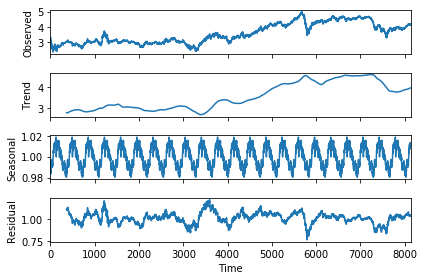

In [77]:
# Transform to logarithmic scale and extract general trend and seasonality
# We choose a cycle frequency of 5 years in order to extract most of the seasonal events out of the trend
frequency = 365*1
crude_price_decomposed = log_scale_and_decompose_time_series(crude_price, 'Dollars_per_barrel', frequency, 
                                                             model='multiplicative', two_sided=False)

In [78]:
# Notice that when decomposing the data, the first "frequency" records (in this case the values of the 
# first 5 years) will be null since there was needed that amount of seasonal information to extract
# correctly the trend and the residuals
crude_price_decomposed.head()

,date (day),Dollars_per_barrel,log_Dollars_per_barrel,log_Dollars_per_barrel_trend,log_Dollars_per_barrel_seasonal,log_Dollars_per_barrel_residual
0,1986-01-02,25.56,3.241029,NaN,0.986717,NaN
1,1986-01-03,26.00,3.258097,NaN,0.988499,NaN
2,1986-01-06,26.53,3.278276,NaN,0.990553,NaN
3,1986-01-07,25.85,3.252311,NaN,0.988748,NaN
4,1986-01-08,25.87,3.253084,NaN,0.986456,NaN


In [79]:
# Remove the first part of the time series used for decomposition
data = crude_price_decomposed.dropna().reset_index(drop=True)

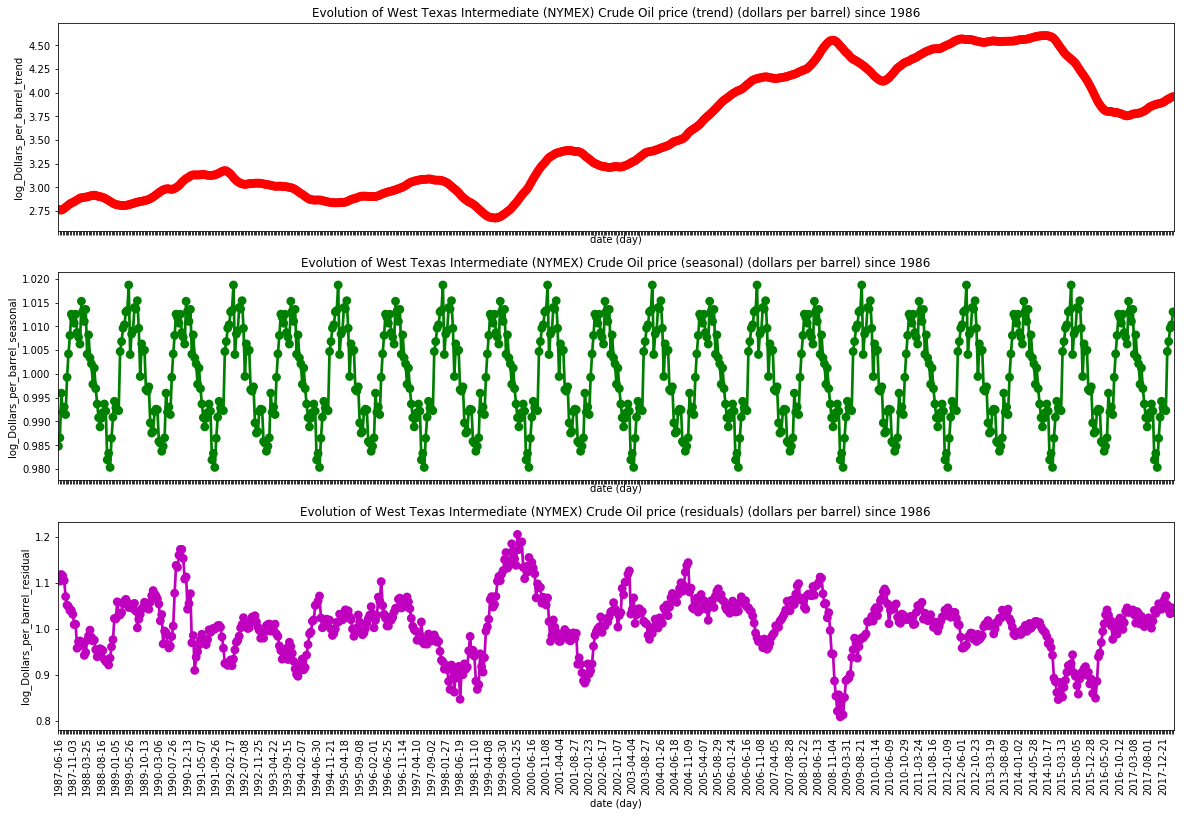

In [80]:
# Visualize trend, seasonality and residuals time series
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(20, 13))
sns.pointplot(x='date (day)',y='log_Dollars_per_barrel_trend', data=data.iloc[::10], color='r', ax=ax1)
sns.pointplot(x='date (day)',y='log_Dollars_per_barrel_seasonal', data=data.iloc[::10], color='g', ax=ax2)
sns.pointplot(x='date (day)',y='log_Dollars_per_barrel_residual', data=data.iloc[::10], color='m', ax=ax3)
ax1.set_title("Evolution of West Texas Intermediate (NYMEX) Crude Oil price (trend) (dollars per barrel) since 1986")
ax2.set_title("Evolution of West Texas Intermediate (NYMEX) Crude Oil price (seasonal) (dollars per barrel) since 1986")
ax3.set_title("Evolution of West Texas Intermediate (NYMEX) Crude Oil price (residuals) (dollars per barrel) since 1986")

for ind, label in enumerate(ax3.get_xticklabels()):
    if ind % 10 == 0:  # every 30th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_ = plt.xticks(rotation=90)

* We can see now clearly in the residuals the most relevant historical events in the prices of crude oil.
* Notice that one can decompose the values by extracting other correlated temporal variables (i.e. global inflaction evolution over time).

## Forecast historical prices through Moving Average and evaluate model

In [81]:
def moving_average_forecast(series_trend, series_seasonal, series_residual, window_size, days_in_advance):
    
    # Calculate moving average forecast for each decomposed behavior using the given window size
    ma_forecast_trend = series_trend.rolling(window=window_size)
    ma_forecast_trend = ma_forecast_trend.mean()
    
    ma_forecast_seasonal = series_seasonal.rolling(window=window_size)
    ma_forecast_seasonal = ma_forecast_seasonal.mean()
    
    ma_forecast_residual = series_residual.rolling(window=window_size)
    ma_forecast_residual = ma_forecast_residual.mean()

    # Format predictions, we want to use the prediction for n_days_in_advance after the current day
    # therefore, we will introduce n - 1 null values to shift the time series
    ma_forecast_trend = pd.concat([pd.Series([np.nan]*(days_in_advance-1)),
                              ma_forecast_trend]).reset_index(drop=True)[:-(days_in_advance-1)]
    ma_forecast_seasonal = pd.concat([pd.Series([np.nan]*(days_in_advance-1)),
                              ma_forecast_seasonal]).reset_index(drop=True)[:-(days_in_advance-1)]
    ma_forecast_residual = pd.concat([pd.Series([np.nan]*(days_in_advance-1)),
                              ma_forecast_residual]).reset_index(drop=True)[:-(days_in_advance-1)]
    
    # Calculate RMSE between prediction and data (reconstructed prices and residuals) with the given days in advance
    ma_forecast_reconstructed = exp_scale_and_recompose_time_series(ma_forecast_trend, ma_forecast_seasonal, 
                                                                    ma_forecast_residual)
    data_reconstructed = exp_scale_and_recompose_time_series(series_trend, series_seasonal, series_residual)
    
    rmse_total = math.sqrt(mean_squared_error(ma_forecast_reconstructed.iloc[window_size:], 
                                              data_reconstructed.iloc[window_size:]))
    rmse_resid = math.sqrt(mean_squared_error(ma_forecast_residual.iloc[window_size:], 
                                              series_residual.iloc[window_size:]))
    
    return rmse_total, rmse_resid, data_reconstructed, ma_forecast_reconstructed, \
            series_residual.iloc[window_size:], ma_forecast_residual.iloc[window_size:]

In [82]:
# Forecast the oil prices by Moving average using different window sizes
window_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 30, 90, 365] # days
days_in_advance = 2
rmses_resid = []
rmses_total = []
true_values = []
predictions = []
true_residuals = []
pred_residuals = []
for w_size in window_sizes:
    rmse_total, rmse_resid, data_reconstructed, ma_forecast_reconstructed, data_resid, ma_pred_resid = moving_average_forecast(\
                                                                                data['log_Dollars_per_barrel_trend'], 
                                                                                data['log_Dollars_per_barrel_seasonal'],
                                                                                data['log_Dollars_per_barrel_residual'],
                                                                                w_size, days_in_advance)
    rmses_total.append(rmse_total)
    rmses_resid.append(rmse_resid)
    true_values.append(data_reconstructed)
    predictions.append(ma_forecast_reconstructed)
    true_residuals.append(data_resid)
    pred_residuals.append(ma_pred_resid)
    
optimization_results = pd.DataFrame({'window_size':window_sizes, 'rmse_resid':rmses_resid, 'rmse_total':rmses_total})

#### Compare performance of Moving Average method with different widow sizes

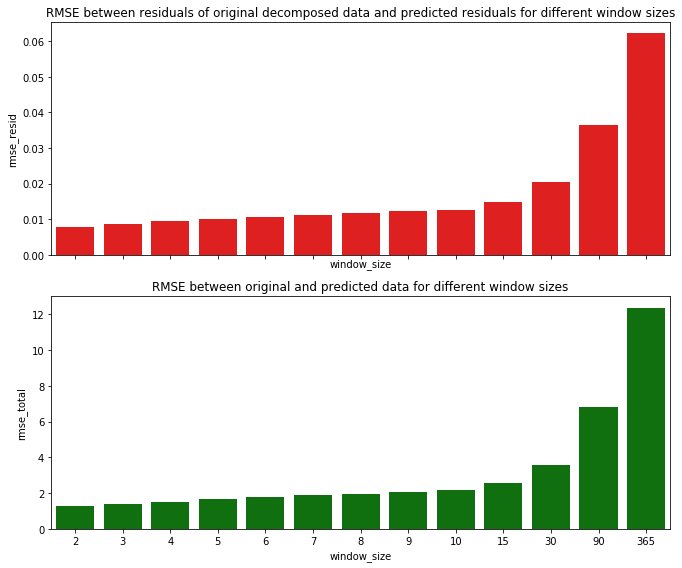

In [83]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
sns.barplot(x="window_size", y="rmse_resid", data=optimization_results, color='r', ax=ax1)
sns.barplot(x="window_size", y="rmse_total", data=optimization_results, color='g', ax=ax2)
ax1.set_title("RMSE between residuals of original decomposed data and predicted residuals for different window sizes")
ax2.set_title("RMSE between original and predicted data for different window sizes")
f.tight_layout()

#### Compare original oil price time series with prediction through moving average and a window size of 2 days

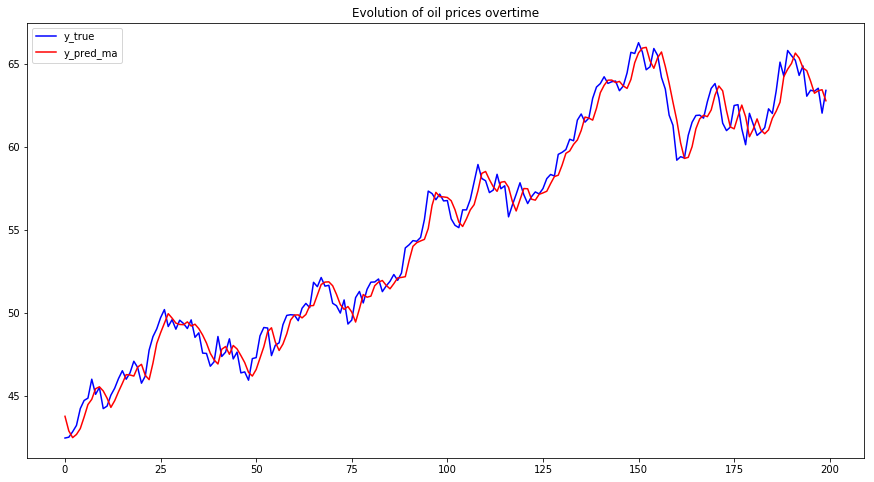

In [142]:
_ = plt.figure(figsize=(15,8))
_ = plt.plot(true_values[0].tolist()[-200:], color='b')
_ = plt.plot(predictions[0].tolist()[-200:], color='r')
_ = plt.title("Evolution of oil prices overtime")
_ = plt.legend(['y_true', 'y_pred_ma'], loc='upper left')

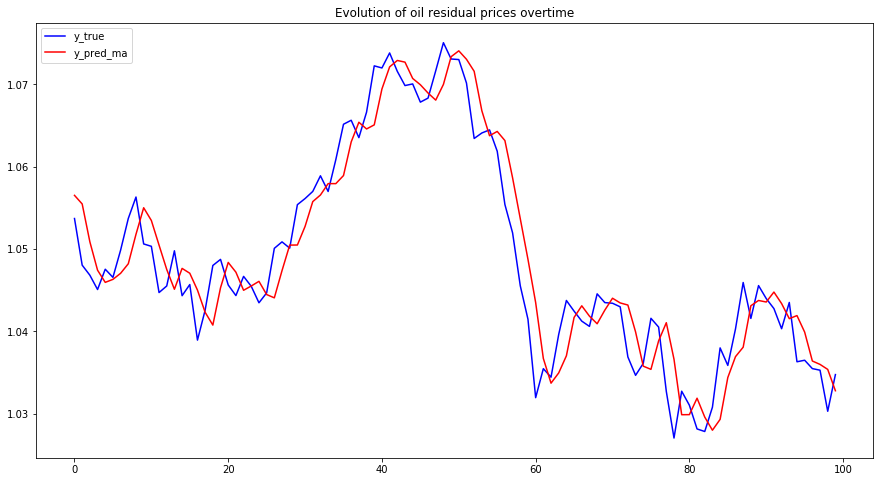

In [141]:
_ = plt.figure(figsize=(15,8))
_ = plt.plot(true_residuals[0].tolist()[-500:], color='b')
_ = plt.plot(pred_residuals[0].tolist()[-500:], color='r')
_ = plt.title("Evolution of oil residual prices overtime")
_ = plt.legend(['y_true', 'y_pred_ma'], loc='upper left')

## Detect anomalies in the oil prices

In [135]:
def calculate_anomaly_threshold(series, n_std):
    # Notice that we consider that our data follows a normal distribution
    mean = series.mean()
    std = series.std()
    
    # calculate intervale acceptable as normality based on given parameters
    ci_min, ci_max = mean - n_std * std, mean + n_std * std
    
    # label data by considering the threshold interval
    is_in = [True if x > ci_min and x < ci_max else False for x in series.tolist()]
    
    return is_in, ci_min, ci_max

In [136]:
is_in, ci_min, ci_max = calculate_anomaly_threshold(pred_residuals[0], 1.5)

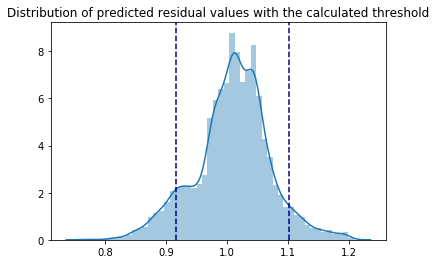

In [137]:
sns.distplot(pred_residuals[0])
_ = plt.axvline(x=ci_min, color='darkblue', linestyle='--')
_ = plt.axvline(x=ci_max, color='darkblue', linestyle='--')
_ = plt.title("Distribution of predicted residual values with the calculated threshold")

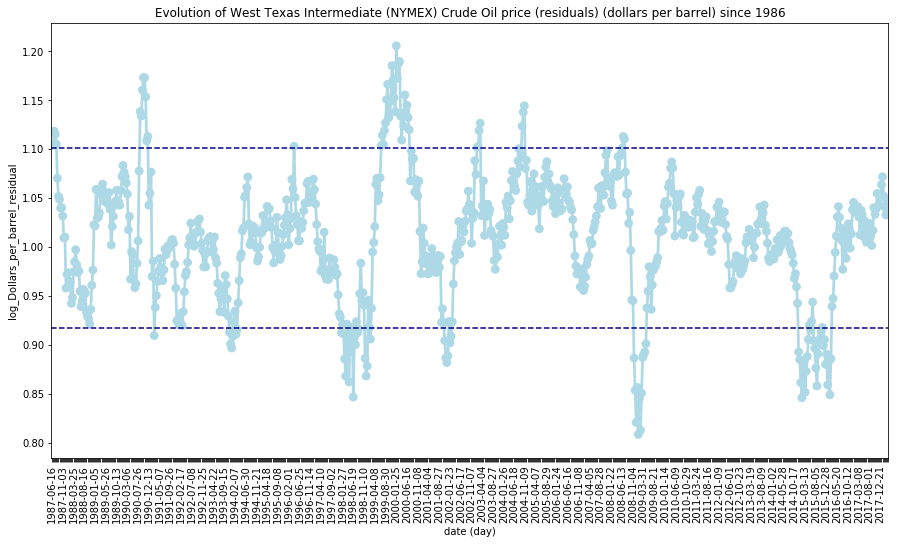

In [138]:
# Visualize trend, seasonality and residuals time series
_ = plt.figure(figsize=(15,8))
ax = sns.pointplot(x='date (day)',y='log_Dollars_per_barrel_residual', data=data.iloc[::10], color='lightblue')
ax.set_title("Evolution of West Texas Intermediate (NYMEX) Crude Oil price (residuals) (dollars per barrel) since 1986")

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 10 == 0:  # every 30th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_ = plt.xticks(rotation=90)
_ = plt.axhline(y=ci_min, color='darkblue', linestyle='--')
_ = plt.axhline(y=ci_max, color='darkblue', linestyle='--')

In [139]:
# Assign labels of values within the given threshold to original data
anomaly_detection_results = pd.DataFrame({'prediction':predictions[0][2:].reset_index(drop=True),'is_normal':is_in, 
              'date (day)': crude_price.tail(len(is_in)-2)['date (day)'].reset_index(drop=True)})

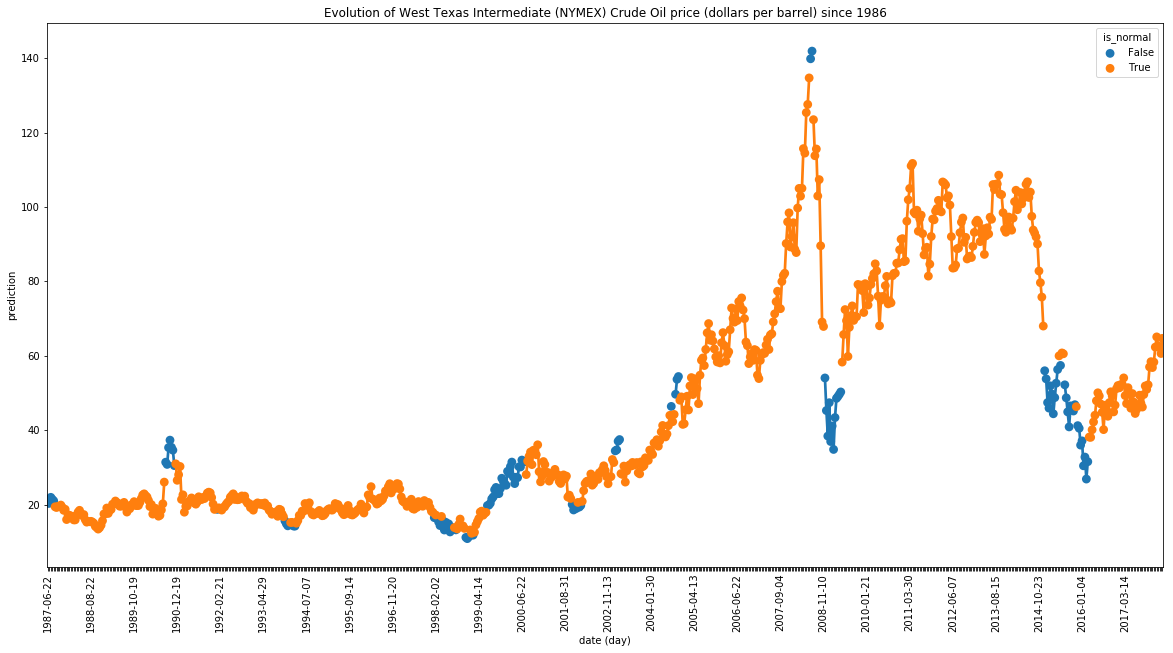

In [140]:
# Original data
plt.figure(figsize=(20,10))

# There are too many points and therefore we will plot only value per each 10
ax = sns.pointplot(x='date (day)',y='prediction', hue='is_normal', data=anomaly_detection_results.iloc[::10])
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 30 == 0:  # every 30th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_ = plt.xticks(rotation=90)
_ = plt.title("Evolution of West Texas Intermediate (NYMEX) Crude Oil price (dollars per barrel) since 1986")

## Conclusions

* We are able to detect anomalies before and during the crisis during the last 40 years.
* We can understand better the impact of a crisis after applying logarithmic scale and decomposing the time series to extract residuals.